In [13]:
import numpy as np
from utils.landscape_class import Protein_Landscape
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV  # default: refit=True
import matplotlib.pyplot as plt
import random

In [14]:
def Stack(arr):
    X, y = arr.T
    
    return np.vstack(X), np.reshape(y, y.shape[0])

def Get_Xy(landscape):

    X = landscape.tokenize_data()
    Y = landscape.data.T[1]
    boolians = landscape.boolean_mutant_array()
    
    mutants = [[], [], [], [], [], []]
    for x, y, boolian in zip(X, Y, boolians):
        B = 0
        for b in boolian:
            if b:
                B += 1


        mutants[B].append([x, y])

    train = np.vstack([mutants[0], mutants[1], mutants[2], mutants[3]])
    test = np.vstack([mutants[4], mutants[5]])
    
    
    X_train, y_train = Stack(train)
    X_test, y_test = Stack(test)
    
    return X_train, y_train, X_test, y_test

In [15]:
saved_nk_landscapes = {"NK-{}".format(x) : [Protein_Landscape(saved_file="K0/V{1}.txt".format(x,y)) for y in range(5)] for x in range(1)}
landscape = saved_nk_landscapes["NK-0"][0]
X_train, y_train, X_test, y_test = Get_Xy(landscape)

K0/V0.txt
K0/V1.txt
K0/V2.txt
K0/V3.txt
K0/V4.txt


/home/niklas/anaconda3/envs/psp_py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [20]:
# faster:
regr = RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=0)    # r2_score = 0.781

# GridSearchCV RF model, might take some few minutes to set parameters (thus out-commented):
#params = {                      # similar parameter grid as Xu et al., https://doi.org/10.1021/acs.jcim.0c00073
#    'random_state': [42],
#    'n_estimators': [100, 250, 500, 1000],  # number of individual decision trees in the forest
#    'max_features': ['auto', 'sqrt', 'log2']  # “auto” -> max_features=n_features,
#    # “sqrt” -> max_features=sqrt(n_features) “log2” -> max_features=log2(n_features)
#}
#regr = GridSearchCV(RandomForestRegressor(), param_grid=params, iid=False, cv=5)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [21]:
stats.spearmanr(y_test, y_pred)

SpearmanrResult(correlation=0.910296766965703, pvalue=0.0)

In [22]:
stats.pearsonr(y_test, y_pred)

(0.9125408208679897, 0.0)

In [23]:
r2_score(y_test, y_pred)

0.7811911092552708

In [24]:
fitness_dict = {str(k):v for k,v in zip(landscape.tokenize_data(), landscape.data.T[1])}

In [25]:
def Mutate(seq):
    mut = seq.copy()
    pos = np.random.randint(5)
    aa = np.random.randint(10)
    mut[pos] = aa
    
    return mut

def Accept(seq, mut):
    seq_fit = regr.predict([seq])
    mut_fit = regr.predict([mut])
        
    if mut_fit >= seq_fit:
        return True
    
    else:
        T = 1e-2
               
        boltz = np.exp(((mut_fit - seq_fit) / T), dtype=np.longfloat)
        p = min(1, boltz)
        
        rand_var = random.random()
        if rand_var < p:
            return True
        else:
            return False

In [26]:
"%.3f"%(np.max(np.concatenate([y_test, y_train])))

'0.903'

In [27]:
ys = []
seq = [0,4,3,9,6]
ys.append(regr.predict([seq]))

accepted = 1
while accepted <= 10:
    mut = Mutate(seq)
    if Accept(seq, mut):
        seq = mut
        ys.append(regr.predict([seq]))
        accepted += 1
print(seq, "%.3f"%(regr.predict([seq])), "%.3f"%(fitness_dict[str(np.array(seq))]), "%.3f"%(np.max(np.concatenate([y_test, y_train]))))

[9, 4, 3, 7, 2] 0.704 0.815 0.903


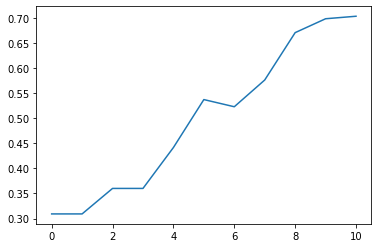

In [28]:
plt.plot(np.arange(11), ys)